<a href="https://colab.research.google.com/github/gomyk/NNStudy/blob/moonwon/%5BRL%5D%5BDDPG%5D%5BMW%5D%20MountainCarContinuous-v0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import modules

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import gym
from gym.wrappers import Monitor
import math
import random
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import base64

from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

from google.colab import output

display = Display(visible=0, size=(400,600),)
display.start()
env = gym.make("MountainCarContinuous-v0")

#env = gym.wrappers.Monitor(gym.make("CartPole-v1"), "video", force=True, video_callable=lambda c:c%100 ==0)

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Replay Memory

In [0]:
class ReplayMemory:
    """A simple numpy replay buffer."""

    def __init__(self, action_dim:int , obs_dim: int, size: int, batch_size: int):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, action_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

##Define Noise Generator

In [0]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

##Actor Network

In [0]:
HIDDEN_SIZE = 128
class Actor(nn.Module):

    def __init__(self, obs_size, outputs, init_w: float = 3e-3,):
        super(Actor, self).__init__()
        self.linear = nn.Linear(obs_size, HIDDEN_SIZE)
        self.linear2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, outputs)

        self.head.weight.data.uniform_(-init_w, init_w)
        self.head.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.linear(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.head(x).tanh()

##Critic Network

In [0]:
class Critic(nn.Module):

    def __init__(self, obs_size, action_size, init_w: float = 3e-3,):
        super(Critic, self).__init__()
        self.linear = nn.Linear(obs_size + action_size, HIDDEN_SIZE)
        self.linear2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, 1)

        self.head.weight.data.uniform_(-init_w, init_w)
        self.head.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.head(x)

###Environment Snapshot

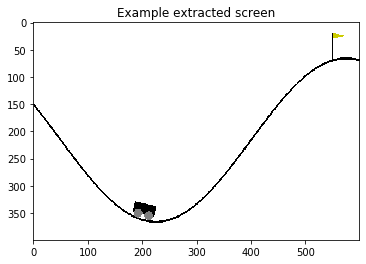

In [7]:
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
plt.title('Example extracted screen')
plt.show()

##Prepare to learning 

In [0]:
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10
ACTOR_LR = 0.001
CRITIC_LR = 0.001
MEMORY_SIZE = 10000
EPISODE_SIZE = 100
TAU = 0.005
ou_noise_theta = 1.0
ou_noise_sigma = 0.1

RECORD_INTERVAL = 10

# gym 행동 공간에서 행동의 숫자를 얻습니다.
#n_actions = env.action_space.n
n_actions = 1
n_obvs = 2

actor = Actor(n_obvs, n_actions).to(device)
actor.eval()
actor_target = Actor(n_obvs, n_actions).to(device)
actor_target.load_state_dict(actor.state_dict())
actor_target.eval()

critic = Critic(n_obvs, n_actions).to(device)
critic.eval()
critic_target = Critic(n_obvs, n_actions).to(device)
critic_target.load_state_dict(critic.state_dict())
critic_target.eval()

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)
memory = ReplayMemory(n_actions,n_obvs,MEMORY_SIZE,BATCH_SIZE)

noise = OUNoise(
            n_actions,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample < eps_threshold:
            #selected_action = [np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1)]
            selected_action = [np.random.uniform(-1,1)]
    else:
        selected_action = actor(
             torch.FloatTensor(state).to(device)
         ).detach().cpu().numpy()
    _noise = noise.sample()
    for action in selected_action:
      action = np.clip(action + _noise, -1.0, 1.0)
    return selected_action
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [0]:
def target_soft_update():
        #Soft-update: target = tau*local + (1-tau)*target
        tau = TAU
        
        for t_param, l_param in zip(
            actor_target.parameters(), actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            critic_target.parameters(), critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

##Optimizer

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return -1 , -1
    samples = memory.sample_batch()
    state = torch.FloatTensor(samples["obs"]).to(device)
    next_state = torch.FloatTensor(samples["next_obs"]).to(device)
    action = torch.FloatTensor(samples["acts"]).to(device)
    reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
    
    masks = 1 - done
    next_action = actor_target(next_state)
    next_value = critic_target(next_state, next_action)
    curr_return = reward + GAMMA * next_value * masks

    # train critic
    values = critic(state, action)
    critic_loss = F.smooth_l1_loss(values, curr_return)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()     
    # train actor
    loss = critic(state, actor(state))
    actor_loss = -loss.mean()
        
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
        
    # target update
    target_soft_update()

    return actor_loss.data, critic_loss.data

##Train

0 episode , 999 step , 0.53 Actor Loss, -0.25 Critic Loss,  0.57 Threshold , -0.32 Top reward
[496, 0, 503]
1 episode , 999 step , 3.56 Actor Loss, 0.00 Critic Loss,  0.36 Threshold , 0.19 Top reward
[540, 0, 459]
2 episode , 999 step , 6.17 Actor Loss, 0.00 Critic Loss,  0.24 Threshold , 0.17 Top reward
[592, 0, 407]
3 episode , 999 step , 8.12 Actor Loss, 0.01 Critic Loss,  0.17 Threshold , 0.10 Top reward
[195, 0, 804]
4 episode , 999 step , 9.06 Actor Loss, 0.01 Critic Loss,  0.12 Threshold , -0.02 Top reward
[65, 0, 934]
5 episode , 999 step , 9.94 Actor Loss, 0.01 Critic Loss,  0.09 Threshold , 0.00 Top reward
[45, 0, 954]
6 episode , 999 step , 10.70 Actor Loss, 0.01 Critic Loss,  0.08 Threshold , -0.05 Top reward
[42, 0, 957]
7 episode , 999 step , 11.45 Actor Loss, 0.01 Critic Loss,  0.07 Threshold , 0.10 Top reward
[28, 0, 971]
8 episode , 999 step , 12.14 Actor Loss, 0.02 Critic Loss,  0.06 Threshold , -0.16 Top reward
[26, 0, 973]
9 episode , 999 step , 12.93 Actor Loss, 0.

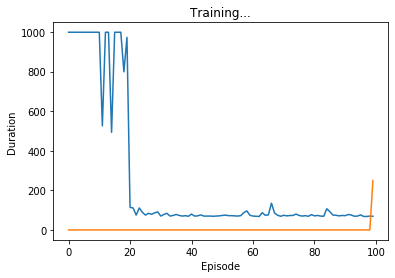

In [11]:
frames = []
for i_episode in range(EPISODE_SIZE):
    # 환경과 상태 초기화
    obv = env.reset()
    total_actor_loss = 0
    total_critic_loss = 0
    global steps_done
    top_reward = -1
    total_action_count = [0,0,0]
    for t in count():
        if i_episode % RECORD_INTERVAL == 0:
          frames.append(env.render(mode="rgb_array"))
        # 행동 선택과 수행
        action = select_action(obv)
        next_obv, reward, done, _ = env.step(action)
        index  = 1
        if action[0] > 0 :
          index = 2
        elif action[0] < 0:
          index = 0
        total_action_count[index] += 1
        reward  = obv[0]
        if reward > top_reward:
          top_reward = reward

        # 메모리에 변이 저장
        assert obv is not None
        memory.store(obv, action, reward, next_obv, done)

        # 다음 상태로 이동
        obv = next_obv

        # 최적화 한단계 수행(목표 네트워크에서)
        actor_loss, critic_loss = optimize_model()
        total_actor_loss += actor_loss
        total_critic_loss += critic_loss
        if done:
            E = eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
            episode_durations.append(t + 1)
            print('%d episode , %d step , %.2f Actor Loss, %.2f Critic Loss,  %.2f Threshold , %.2f Top reward'\
                  %(i_episode,t+1,total_actor_loss/(t+1), total_critic_loss/(t+1) ,E, top_reward))
            print(total_action_count)
            plot_durations()
            total_actor_loss = 0
            total_critic_loss = 0
            top_reward = 0
            total_action_count = [0,0,0]
            break
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        actor_target.load_state_dict(actor.state_dict())
        critic_target.load_state_dict(critic.state_dict())
print('Complete')
env.render()
env.close()
plt.show()

## Rendering

In [12]:
!pip install JSAnimation
from matplotlib import animation, rc
from JSAnimation.IPython_display import display_animation
from IPython.display import display

import os
import glob
import io

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11425 sha256=f603e07e296ebc880500d5366bd998670580efbc98242af878b0ca3e66ea1b10
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [0]:
def show_video():
  mp4list = glob.glob('./*.mp4')
  if len(mp4list) > 0:
    print(mp4list)
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

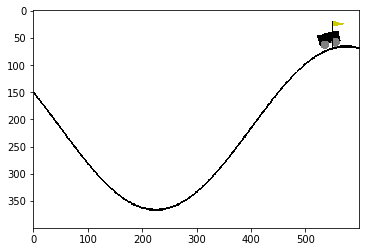

In [14]:
# Imports specifically so we can render outputs in Colab.
fig = plt.figure()
def display_frames_as_gif(frame):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frame[0].astype(int))
    def animate(i):
        patch.set_data(frame[i].astype(int))

    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=30, blit=False
    )
    #display(display_animation(anim, default_mode='loop'))
    # Set up formatting for the movie files
    display(HTML(data=anim.to_html5_video()))
    #FFwriter = animation.FFMpegWriter()
    #anim.save('basic_animation.mp4', writer = FFwriter)
    #show_video()
# display 
display_frames_as_gif(frames)